<a href="https://colab.research.google.com/github/bitanb1999/Summer-Analytics-2021/blob/main/SA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Summer Analytics Capstone Project

####Pre-requisites

In [1]:
import numpy as np
import scipy.stats
import scipy.special
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from matplotlib import cm
import pandas as pd
from sklearn.pipeline import make_pipeline, make_union, Pipeline
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from math import sqrt
from keras.models import Sequential
from keras.models import Model as KerasModel
from keras.layers import Input, Dense, Activation, Reshape
from keras.layers import Concatenate
from keras.layers.embeddings import Embedding
from sklearn.ensemble import RandomForestRegressor
from sklearn import linear_model
import pickle
import csv
from datetime import datetime
from sklearn import preprocessing
from keras.callbacks import ModelCheckpoint
import xgboost as xgb
from sklearn.preprocessing import OneHotEncoder

#Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer

#For Missing Value and Feature Engineering
from sklearn.feature_selection import SelectKBest, chi2, f_classif, VarianceThreshold
from sklearn.impute import SimpleImputer, KNNImputer, MissingIndicator
from sklearn.preprocessing import KBinsDiscretizer, LabelEncoder, MinMaxScaler
from sklearn.decomposition import PCA

from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from xgboost import XGBRegressor

import time
import seaborn as sns
%matplotlib inline

###Data:

In [2]:
## getting the data
train=pd.read_csv("/content/Train_Data.csv")
test=pd.read_csv("/content/Test_Data.csv")

In [3]:
train.head()

,date,campaign,adgroup,ad,impressions,clicks,cost,conversions,revenue
0,01-08-2020,campaign 1,adgroup 1,ad 1,24,6,0.08,0,0.00
1,01-08-2020,campaign 1,adgroup 2,ad 1,1,0,0.00,0,0.00
2,01-08-2020,campaign 1,adgroup 3,ad 1,13,4,0.04,0,0.00
3,01-08-2020,campaign 1,adgroup 4,ad 1,5,4,0.08,0,0.00
4,01-08-2020,campaign 1,adgroup 1,ad 2,247,126,1.29,4,925.71


In [4]:
test.head()

,date,campaign,adgroup,ad,cost,impressions,clicks,conversions
0,01-03-2021,campaign 1,adgroup 1,ad 1,0.58,121,49,1
1,01-03-2021,campaign 1,adgroup 3,ad 1,0.17,22,12,0
2,01-03-2021,campaign 1,adgroup 4,ad 1,0.05,5,3,0
3,01-03-2021,campaign 1,adgroup 2,ad 1,0.01,2,1,0
4,01-03-2021,campaign 1,adgroup 2,ad 2,0.01,3,1,0


In [5]:
#helper function to view the table content details
from IPython.display import display, HTML

def pretty_print(df):
    return display( HTML( df.to_html().replace("\\n","<br>") ) )
def tbl_report(tbl, cols=None, card=52):
    print("Table Shape", tbl.shape)
    dtypes = tbl.dtypes
    nulls = []
    uniques = []
    numuniques = []
    vcs = []
    for col in dtypes.index:
        n = tbl[col].isnull().sum()
        nulls.append(n)
        strdtcol = str(dtypes[col])
        #if strdtcol == 'object' or strdtcol[0:3] == 'int' or strdtcol[0:3] == 'int':
        #print(strdtcol)
        uniqs = tbl[col].unique()
        uniquenums = uniqs.shape[0]
        if uniquenums < card: # low cardinality
            valcounts = pd.value_counts(tbl[col], dropna=False)
            vc = "\n".join(["{}:{}".format(k,v) for k, v in valcounts.items()])
        else:
            vc='NA'
        uniques.append(uniqs)
        numuniques.append(uniquenums)
        vcs.append(vc)
    nullseries = pd.Series(nulls, index=dtypes.index)
    uniqueseries = pd.Series(uniques, index=dtypes.index)
    numuniqueseries = pd.Series(numuniques, index=dtypes.index)
    vcseries = pd.Series(vcs, index=dtypes.index)
    df = pd.concat([dtypes, nullseries, uniqueseries, numuniqueseries, vcseries], axis=1)
    df.columns = ['dtype', 'nulls', 'uniques', 'num_uniques', 'value_counts']
    if cols:
        return pretty_print(df[cols])
    return pretty_print(df)

In [6]:
tbl_report(train)

Table Shape (4571, 9)


,dtype,nulls,uniques,num_uniques,value_counts
date,object,0,"[01-08-2020, 02-08-2020, 03-08-2020, 04-08-2020, 05-08-2020, 06-08-2020, 07-08-2020, 08-08-2020, 09-08-2020, 10-08-2020, 11-08-2020, 12-08-2020, 13-08-2020, 14-08-2020, 15-08-2020, 16-08-2020, 17-08-2020, 18-08-2020, 19-08-2020, 20-08-2020, 21-08-2020, 22-08-2020, 23-08-2020, 24-08-2020, 25-08-2020, 26-08-2020, 27-08-2020, 28-08-2020, 29-08-2020, 30-08-2020, 31-08-2020, 01-09-2020, 02-09-2020, 03-09-2020, 04-09-2020, 05-09-2020, 06-09-2020, 07-09-2020, 08-09-2020, 09-09-2020, 10-09-2020, 11-09-2020, 12-09-2020, 13-09-2020, 14-09-2020, 15-09-2020, 16-09-2020, 17-09-2020, 18-09-2020, 19-09-2020, 20-09-2020, 21-09-2020, 22-09-2020, 23-09-2020, 24-09-2020, 25-09-2020, 26-09-2020, 27-09-2020, 28-09-2020, 29-09-2020, 30-09-2020, 01-10-2020, 02-10-2020, 03-10-2020, 04-10-2020, 05-10-2020, 06-10-2020, 07-10-2020, 08-10-2020, 09-10-2020, 10-10-2020, 11-10-2020, 12-10-2020, 13-10-2020, 14-10-2020, 15-10-2020, 16-10-2020, 17-10-2020, 18-10-2020, 19-10-2020, 20-10-2020, 21-10-2020, 22-10-2020, 23-10-2020, 24-10-2020, 25-10-2020, 26-10-2020, 27-10-2020, 28-10-2020, 29-10-2020, 30-10-2020, 31-10-2020, 01-11-2020, 02-11-2020, 03-11-2020, 04-11-2020, 05-11-2020, 06-11-2020, 07-11-2020, 08-11-2020, ...]",212,NA
campaign,object,0,[campaign 1],1,campaign 1:4571
adgroup,object,0,"[adgroup 1, adgroup 2, adgroup 3, adgroup 4]",4,adgroup 3:1672adgroup 1:1314adgroup 4:858adgroup 2:727
ad,object,0,"[ad 1, ad 2, ad 3, ad 4, ad 5, ad 6, ad 7, ad 8, ad 9, ad 10, ad 11, ad 12, ad 13, ad 14, ad 15, ad 16, ad 17, ad 18, ad 19, ad 20, ad 21, ad 22, ad 23, ad 24, ad 25, ad 26, ad 27, ad 28, ad 29, ad 30, ad 31, ad 32, ad 33, ad 34, ad 35, ad 36, ad 37, ad 38, ad 39, ad 40, ad 41, ad 42, ad 43, ad 44, ad 45, ad 46, ad 47, ad 48, ad 49, ad 50, ad 51, ad 52, ad 53, ad 54, ad 55, ad 56, ad 57, ad 58, ad 59, ad 60, ad 61, ad 62, ad 63, ad 64, ad 65, ad 66, ad 67, ad 68, ad 69, ad 70]",70,NA
impressions,int64,0,"[24, 1, 13, 5, 247, 7, 6, 129, 104, 4, 39, 17, 253, 16, 26, 250, 261, 329, 2, 21, 197, 11, 105, 62, 10, 258, 31, 243, 212, 3, 245, 12, 49, 304, 9, 140, 116, 68, 22, 218, 138, 15, 19, 40, 272, 131, 128, 54, 297, 25, 216, 173, 144, 8, 309, 163, 142, 55, 20, 278, 34, 18, 256, 44, 443, 148, 201, 52, 14, 282, 60, 489, 158, 190, 48, 291, 524, 206, 66, 348, 45, 440, 169, 241, 71, 311, 23, 496, 89, 70, 280, 75, 324, 81, 442, 117, 152, 61, 289, 47, ...]",571,NA
clicks,int64,0,"[6, 0, 4, 126, 2, 3, 52, 56, 5, 16, 128, 10, 114, 123, 130, 8, 112, 1, 68, 40, 139, 9, 14, 117, 79, 140, 13, 7, 156, 60, 46, 39, 129, 95, 73, 78, 18, 37, 54, 21, 161, 11, 122, 64, 67, 155, 84, 28, 150, 15, 138, 211, 71, 27, 154, 250, 76, 59, 30, 179, 23, 136, 237, 96, 31, 119, 12, 203, 75, 33, 148, 35, 146, 36, 229, 92, 132, 34, 149, 210, 38, 85, 32, 135, 22, 165, 61, 118, 218, 53, 17, 125, 24, 191, 86, 29, 47, 93, 109, 142, ...]",355,NA
cost,float64,0,"[0.08, 0.0, 0.04, 1.29, 0.05, 0.58, 0.56, 0.22, 0.06, 1.32, 0.07, 0.1, 1.17, 1.27, 1.4, 0.02, 0.09, 0.18, 1.18, 0.01, 0.69, 0.46, 0.44, 1.43, 0.15, 1.21, 0.86, 1.44, 0.13, 1.75, 0.64, 0.03, 0.41, 1.38, 1.04, 0.78, 0.88, 0.21, 1.54, 0.62, 0.23, 1.72, 0.12, 1.33, 0.75, 0.85, 1.73, 0.9, 0.42, 0.35, 1.61, 0.11, 0.16, 1.52, 0.28, 2.48, 0.74, 0.34, 1.7, 0.32, 1.42, 2.69, 0.66, 0.33, 1.9, 0.26, 0.14, 1.46, 2.81, 1.09, 1.28, 1.58, 2.36, 0.82, 0.36, 1.53, 0.37, 0.4, 0.98, 0.3, 1.41, 1.59, 0.29, 2.29, 0.43, 1.0, 0.27, 1.87, 0.71, 1.3, 0.38, 2.41, 0.59, 0.2, 2.12, 0.97, 0.77, 0.52, 1.05, 1.5, ...]",810,NA
conversions,int64,0,"[0, 4, 2, 3, 9, 1, 5, 6, 7, 8, 10, 19, 12, 16, 23, 22, 15, 14, 24, 36, 18, 40, 61, 47, 82, 91, 11, 17, 44, 27, 28, 74, 71, 63, 42, 37, 85, 13, 39, 48, 56, 68, 94, 43, 79, 59, 34, 26, 52]",49,0:32131:5422:2343:1174:1056:795:767:489:358:2810:1112:711:714:723:619:513:415:322:327:318:317:316:236:282:240:247:226:152:171:163:194:124:128:144:148:168:156:134:159:143:174:137:161:185:139:142:179:191:1
revenue,float64,0,"[0.0, 925.71, 339.83, 384.22, 337.57, 397.59, 1476.67, 188.83, 2

In [7]:
tbl_report(test)

Table Shape (318, 8)


,dtype,nulls,uniques,num_uniques,value_counts
date,object,0,"[01-03-2021, 02-03-2021, 03-03-2021, 04-03-2021, 05-03-2021, 06-03-2021, 07-03-2021, 08-03-2021, 09-03-2021, 10-03-2021, 11-03-2021, 12-03-2021, 13-03-2021, 14-03-2021, 15-03-2021]",15,03-03-2021:2808-03-2021:2613-03-2021:2509-03-2021:2515-03-2021:2512-03-2021:2411-03-2021:2414-03-2021:2410-03-2021:2305-03-2021:2101-03-2021:1902-03-2021:1906-03-2021:1207-03-2021:1204-03-2021:11
campaign,object,0,[campaign 1],1,campaign 1:318
adgroup,object,0,"[adgroup 1, adgroup 3, adgroup 4, adgroup 2]",4,adgroup 3:111adgroup 1:90adgroup 2:63adgroup 4:54
ad,object,0,"[ad 1, ad 2, ad 3, ad 4, ad 5, ad 6, ad 7, ad 8, ad 10, ad 71, ad 72, ad 73, ad 74, ad 75, ad 56, ad 55]",16,ad 3:44ad 1:42ad 7:33ad 2:30ad 56:24ad 72:22ad 55:19ad 73:13ad 10:13ad 74:12ad 5:11ad 4:11ad 8:11ad 6:11ad 75:11ad 71:11
cost,float64,0,"[0.58, 0.17, 0.05, 0.01, 0.03, 1.67, 0.0, 1.06, 0.08, 1.64, 0.1, 0.88, 0.02, 0.3, 0.16, 0.98, 0.22, 0.24, 0.65, 1.57, 1.65, 1.36, 0.07, 0.99, 0.46, 0.13, 0.04, 0.94, 0.12, 0.09, 0.18, 0.34, 0.4, 0.14, 0.25, 0.87, 0.81, 0.06, 2.05, 0.67, 1.69, 0.56, 1.59, 1.66, 1.54, 0.91, 1.4, 0.7, 1.07, 0.2, 0.49, 1.94, 2.9, 0.72, 0.32, 0.31, 0.27, 0.55, 0.66, 0.61, 3.36, 2.67, 0.45, 0.78, 0.63, 3.53, 3.47, 0.77, 0.47, 0.62, 1.49, 1.62, 1.21, 1.03, 0.15, 0.44, 0.9, 1.29, 1.15, 0.21, 0.93, 0.29, 0.37, 0.85, 1.16, 1.0, 0.43, 1.17, 1.27, 1.41, 0.97, 0.19, 1.08, 1.39, 0.26, 0.28, 0.11, 0.73, 1.58, 0.41, ...]",109,NA
impressions,int64,0,"[121, 22, 5, 2, 3, 4, 276, 6, 162, 294, 15, 152, 94, 25, 191, 24, 27, 112, 281, 1, 298, 196, 7, 31, 12, 151, 103, 23, 178, 29, 13, 42, 45, 68, 20, 9, 127, 192, 316, 134, 306, 91, 258, 347, 269, 173, 67, 263, 123, 14, 238, 40, 62, 10, 362, 418, 137, 66, 54, 48, 75, 106, 116, 502, 558, 77, 131, 125, 111, 560, 589, 153, 161, 8, 260, 308, 167, 35, 207, 16, 108, 201, 210, 228, 18, 139, 30, 26, 174, 78, 169, 166, 248, 113, 37, 165, 32, 60, 28, 85, ...]",128,NA
clicks,int64,0,"[49, 12, 3, 1, 2, 123, 0, 74, 5, 110, 14, 7, 82, 30, 79, 18, 48, 126, 122, 97, 4, 88, 39, 11, 75, 10, 8, 21, 27, 13, 6, 22, 69, 64, 145, 55, 125, 40, 121, 137, 119, 77, 31, 115, 54, 16, 38, 155, 215, 61, 28, 24, 51, 236, 232, 32, 45, 63, 52, 261, 276, 34, 59, 135, 136, 95, 93, 15, 89, 44, 84, 94, 96, 76, 9, 41, 90, 62, 86, 102, 85, 103, 17, 83, 81, 91, 57, 68, 26, 92, 114, 19, 37, 67, 116, 134, 73, 80]",98,NA
conversions,int64,0,"[1, 0, 3, 2, 4, 6, 8, 14, 13, 15, 5]",11,0:2111:502:263:134:86:35:315:114:113:18:1


###Feature Engineering and EDA:

In [8]:
train.columns[4:-1]

Index(['impressions', 'clicks', 'cost', 'conversions'], dtype='object')

In [9]:
from datetime import datetime

# This function is to extract date features
def date_process(df):
    df["date"] = pd.to_datetime(df["date"]) # seting the column as pandas datetime
    df["weekday"] = df['date'].dt.weekday #extracting week day
    df["day"] = df['date'].dt.day # extracting day
    df["month"] = df['date'].dt.month # extracting day
    df["year"] = df['date'].dt.year # extracting day
    
    return df

train = date_process(train)
test = date_process(test)

In [10]:
train.head()

,date,campaign,adgroup,ad,impressions,clicks,cost,conversions,revenue,weekday,day,month,year
0,2020-01-08,campaign 1,adgroup 1,ad 1,24,6,0.08,0,0.00,2,8,1,2020
1,2020-01-08,campaign 1,adgroup 2,ad 1,1,0,0.00,0,0.00,2,8,1,2020
2,2020-01-08,campaign 1,adgroup 3,ad 1,13,4,0.04,0,0.00,2,8,1,2020
3,2020-01-08,campaign 1,adgroup 4,ad 1,5,4,0.08,0,0.00,2,8,1,2020
4,2020-01-08,campaign 1,adgroup 1,ad 2,247,126,1.29,4,925.71,2,8,1,2020


In [11]:
test.head()

,date,campaign,adgroup,ad,cost,impressions,clicks,conversions,weekday,day,month,year
0,2021-01-03,campaign 1,adgroup 1,ad 1,0.58,121,49,1,6,3,1,2021
1,2021-01-03,campaign 1,adgroup 3,ad 1,0.17,22,12,0,6,3,1,2021
2,2021-01-03,campaign 1,adgroup 4,ad 1,0.05,5,3,0,6,3,1,2021
3,2021-01-03,campaign 1,adgroup 2,ad 1,0.01,2,1,0,6,3,1,2021
4,2021-01-03,campaign 1,adgroup 2,ad 2,0.01,3,1,0,6,3,1,2021


In [12]:
constant_columns = [col for col in train.columns if train[col].nunique() == 1]
print(f'Columns : {constant_columns}, \n Num of Columns : {len(constant_columns)}')


train.drop(constant_columns, axis=1, inplace=True)

Columns : ['campaign'], 
 Num of Columns : 1


In [13]:
test.drop(constant_columns, axis=1, inplace=True)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



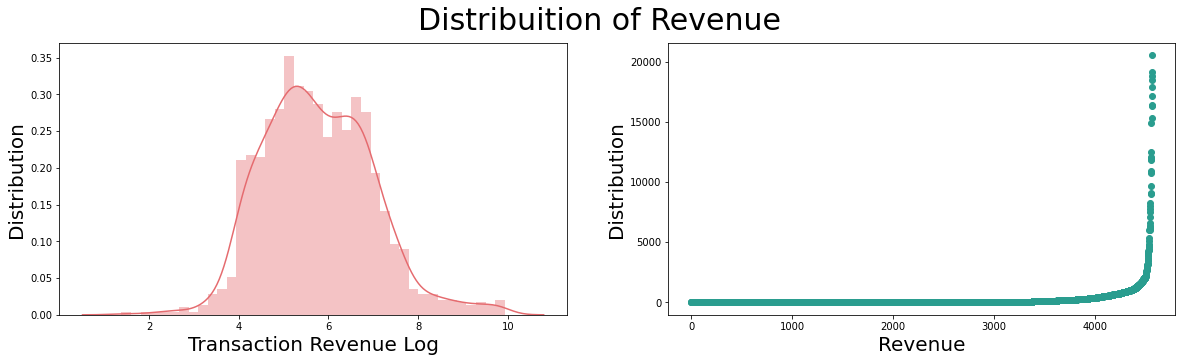

In [ ]:
fig = plt.figure(figsize=(20,5))
plt.suptitle('Distribuition of Revenue', fontsize=30)

ax1 = fig.add_subplot(121)
_ = sns.distplot(np.log(train[train['revenue'] > 0]["revenue"]), bins=40,color='#e56b6f', ax=ax1)
_ = ax1.set_ylabel('Distribution', fontsize=20)
_ = ax1.set_xlabel('Transaction Revenue Log', fontsize=20)


ax2 = fig.add_subplot(122)
_ = plt.scatter(range(train.shape[0]), np.sort(train['revenue'].values), color='#2a9d8f')
_ = ax2.set_ylabel('Distribution', fontsize=20)
_ = ax2.set_xlabel('Revenue', fontsize=20)

In [15]:
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

def CalOutliers(df_num): 

    # calculating mean and std of the array
    data_mean, data_std = np.mean(df_num), np.std(df_num)

    # seting the cut line to both higher and lower values
    # You can change this value
    cut = data_std * 3

    #Calculating the higher and lower cut values
    # You can change this value
    cut = data_std * 3

    #Calculating the higher and lower cut values
    lower, upper = data_mean - cut, data_mean + cut

    # creating an array of lower, higher and total outlier values 
    outliers_lower = [x for x in df_num if x < lower]
    outliers_higher = [x for x in df_num if x > upper]
    outliers_total = [x for x in df_num if x < lower or x > upper]

    # array without outlier values
    outliers_removed = [x for x in df_num if x > lower and x < upper]
    
    print(color.BOLD+f'Lower outliers: {len(outliers_lower)}'+ color.END) # printing total number of values in lower cut of outliers
    print(color.BOLD+f'Upper outliers: {len(outliers_higher)}'+ color.END) # printing total number of values in higher cut of outliers
    print(color.BOLD+f'Total outliers: {len(outliers_total)}'+ color.END) # printing total number of values outliers of both sides
    print(color.BOLD+f'Non - outliers: {len(outliers_removed)}'+ color.END) # printing total number of non outlier values
    print(color.BOLD+f'% of Outliers : {round((len(outliers_total) / len(outliers_removed) )*100, 4)}'+ color.END ) # Percentage of outliers in points
    return outliers_removed

In [16]:
out=CalOutliers(train['revenue'])

Lower outliers: 0
Upper outliers: 46
Total outliers: 46
Non - outliers: 4525
% of Outliers : 1.0166


In [18]:
train=train[train.revenue.isin(out)]

In [19]:
train

,date,adgroup,ad,impressions,clicks,cost,conversions,revenue,weekday,day,month,year
0,2020-01-08,adgroup 1,ad 1,24,6,0.08,0,0.00,2,8,1,2020
1,2020-01-08,adgroup 2,ad 1,1,0,0.00,0,0.00,2,8,1,2020
2,2020-01-08,adgroup 3,ad 1,13,4,0.04,0,0.00,2,8,1,2020
3,2020-01-08,adgroup 4,ad 1,5,4,0.08,0,0.00,2,8,1,2020
4,2020-01-08,adgroup 1,ad 2,247,126,1.29,4,925.71,2,8,1,2020
...,...,...,...,...,...,...,...,...,...,...,...,...
4566,2021-02-28,adgroup 3,ad 55,19,6,0.07,0,0.00,6,28,2,2021
4567,2021-02-28,adgroup 4,ad 55,1,0,0.00,0,0.00,6,28,2,2021
4568,2021-02-28,adgroup 3,ad 56,16,8,0.12,1,93.20,6,28,2,2021
4569,2021-02-28,adgroup 1,ad 56,37,13,0.23,0,0.00,6,28,2,2021


In [ ]:
import plotly
import plotly.offline as plty
from plotly import tools
import plotly.express as px
from plotly.offline import init_notebook_mode, iplot, plot 
import plotly.graph_objs as go
train['ad'].value_counts()[:10].reset_index()


def horizontal_bar_chart(cnt_srs, color):
    trace = go.Bar(
        y=cnt_srs.index[::-1],
        x=cnt_srs.values[::-1],
        showlegend=False,
        orientation = 'h',
        marker=dict(
            color=color,
        ),
    )
    return trace
#adgroups
cnt_srs = train.groupby('ad')['revenue'].agg(['size', 'sum', 'mean'])
cnt_srs.columns = ["count", "total revenue", "mean"]
cnt_srs = cnt_srs.sort_values(by="count", ascending=False)
trace1 = horizontal_bar_chart(cnt_srs["count"].head(10), '#073b4c')
trace2 = horizontal_bar_chart(cnt_srs["total revenue"].head(10), '#073b4c')
trace3 = horizontal_bar_chart(cnt_srs["mean"].head(10), '#073b4c')

# adgroups
cnt_srs = train.groupby('adgroup')['revenue'].agg(['size', 'sum', 'mean'])
cnt_srs.columns = ["count", "total revenue", "mean"]
cnt_srs = cnt_srs.sort_values(by="count", ascending=False)
trace4 = horizontal_bar_chart(cnt_srs["count"].head(10), '#118ab2')
trace5 = horizontal_bar_chart(cnt_srs["total revenue"].head(10), '#118ab2')
trace6 = horizontal_bar_chart(cnt_srs["mean"].head(10), '#118ab2')
# Creating two subplots
fig = plotly.subplots.make_subplots(rows=2, cols=3, vertical_spacing=0.04, 
                          subplot_titles=["Ads - Count", "Ads- Total Revenue", "Ads- Mean Revenue",
                                          "AdGroups- Count",  "AdGroups - Total Revenue ", "AdGroups - Mean Revenue", 
                                          ])

fig.append_trace(trace1, 1, 1)
fig.append_trace(trace2, 1, 2)
fig.append_trace(trace3, 1, 3)
fig.append_trace(trace4, 2, 1)
fig.append_trace(trace5, 2, 2)
fig.append_trace(trace6, 2, 3)
fig['layout'].update(height=1200, width=1500, template='plotly_white',paper_bgcolor='#ffffff', title="Device Plots")
plty.iplot(fig, filename='adsection-plots')

In [ ]:
#seting some static color options
color_op = ['#5527A0', '#BB93D7', '#834CF7', '#6C941E', '#93EAEA', '#7425FF', '#F2098A', '#7E87AC', 
            '#EBE36F', '#7FD394', '#49C35D', '#3058EE', '#44FDCF', '#A38F85', '#C4CEE0', '#B63A05', 
            '#4856BF', '#F0DB1B', '#9FDBD9', '#B123AC']

# Visits by time train

# couting all entries by date to get number of conversions by each date
dates_temp = train['date'].value_counts().reset_index().sort_values('index') 
# renaming the columns to apropriate names
dates_temp.columns = ['date','conversions'] 

# creating the first trace with the necessary parameters
trace = go.Scatter(x=dates_temp.date.astype(str), y=dates_temp.conversions,
                    opacity = 0.8, line = dict(color = '#38C788'), name= 'Conversions by day')
# Below we will get the total values by Transaction Revenue Log by date
dates_temp_sum = train.groupby('date')['revenue'].sum().reset_index()

# using the new dates_temp_sum we will create the second trace
trace1 = go.Scatter(x=dates_temp_sum.date.astype(str), line = dict(color = '#C73877'), name="RevenueLog by day",
                        y=dates_temp_sum['revenue'], opacity = 0.8)

# Getting the total values by Transactions by each date
dates_temp_count = train[train['revenue'] > 0].groupby('date')['revenue'].count().reset_index()

# using the new dates_temp_count we will create the third trace
trace2 = go.Scatter(x=dates_temp_count.date.astype(str), line = dict(color = color_op[5]), name="Sellings by day",
                        y=dates_temp_count['revenue'], opacity = 0.8)

#creating the layout the will allow us to give an title and 
# give us some interesting options to handle with the outputs of graphs
layout = dict(
    title= "Informations by Date",
    paper_bgcolor='#ffffff',
    template='plotly_white',
    xaxis=dict(
        rangeselector=dict(
            buttons=list([
                dict(count=1, label='1m', step='month', stepmode='backward'),
                dict(count=3, label='3m', step='month', stepmode='backward'),
                dict(count=6, label='6m', step='month', stepmode='backward'),
                dict(step='all')
            ])
        ),
        rangeslider=dict(visible = True),
        type='date'
    )
)

# creating figure with the both traces and layout
fig = dict(data= [trace, trace1, trace2], layout=layout)

#rendering the graphs
iplot(fig) #it's an equivalent to plt.show()


In [ ]:
tbl_report(train)

Table Shape (4571, 12)


,dtype,nulls,uniques,num_uniques,value_counts
date,datetime64[ns],0,"[2020-01-08T00:00:00.000000000, 2020-02-08T00:00:00.000000000, 2020-03-08T00:00:00.000000000, 2020-04-08T00:00:00.000000000, 2020-05-08T00:00:00.000000000, 2020-06-08T00:00:00.000000000, 2020-07-08T00:00:00.000000000, 2020-08-08T00:00:00.000000000, 2020-09-08T00:00:00.000000000, 2020-10-08T00:00:00.000000000, 2020-11-08T00:00:00.000000000, 2020-12-08T00:00:00.000000000, 2020-08-13T00:00:00.000000000, 2020-08-14T00:00:00.000000000, 2020-08-15T00:00:00.000000000, 2020-08-16T00:00:00.000000000, 2020-08-17T00:00:00.000000000, 2020-08-18T00:00:00.000000000, 2020-08-19T00:00:00.000000000, 2020-08-20T00:00:00.000000000, 2020-08-21T00:00:00.000000000, 2020-08-22T00:00:00.000000000, 2020-08-23T00:00:00.000000000, 2020-08-24T00:00:00.000000000, 2020-08-25T00:00:00.000000000, 2020-08-26T00:00:00.000000000, 2020-08-27T00:00:00.000000000, 2020-08-28T00:00:00.000000000, 2020-08-29T00:00:00.000000000, 2020-08-30T00:00:00.000000000, 2020-08-31T00:00:00.000000000, 2020-01-09T00:00:00.000000000, 2020-02-09T00:00:00.000000000, 2020-03-09T00:00:00.000000000, 2020-04-09T00:00:00.000000000, 2020-05-09T00:00:00.000000000, 2020-06-09T00:00:00.000000000, 2020-07-09T00:00:00.000000000, 2020-08-09T00:00:00.000000000, 2020-09-09T00:00:00.000000000, 2020-10-09T00:00:00.000000000, 2020-11-09T00:00:00.000000000, 2020-12-09T00:00:00.000000000, 2020-09-13T00:00:00.000000000, 2020-09-14T00:00:00.000000000, 2020-09-15T00:00:00.000000000, 2020-09-16T00:00:00.000000000, 2020-09-17T00:00:00.000000000, 2020-09-18T00:00:00.000000000, 2020-09-19T00:00:00.000000000, 2020-09-20T00:00:00.000000000, 2020-09-21T00:00:00.000000000, 2020-09-22T00:00:00.000000000, 2020-09-23T00:00:00.000000000, 2020-09-24T00:00:00.000000000, 2020-09-25T00:00:00.000000000, 2020-09-26T00:00:00.000000000, 2020-09-27T00:00:00.000000000, 2020-09-28T00:00:00.000000000, 2020-09-29T00:00:00.000000000, 2020-09-30T00:00:00.000000000, 2020-01-10T00:00:00.000000000, 2020-02-10T00:00:00.000000000, 2020-03-10T00:00:00.000000000, 2020-04-10T00:00:00.000000000, 2020-05-10T00:00:00.000000000, 2020-06-10T00:00:00.000000000, 2020-07-10T00:00:00.000000000, 2020-08-10T00:00:00.000000000, 2020-09-10T00:00:00.000000000, 2020-10-10T00:00:00.000000000, 2020-11-10T00:00:00.000000000, 2020-12-10T00:00:00.000000000, 2020-10-13T00:00:00.000000000, 2020-10-14T00:00:00.000000000, 2020-10-15T00:00:00.000000000, 2020-10-16T00:00:00.000000000, 2020-10-17T00:00:00.000000000, 2020-10-18T00:00:00.000000000, 2020-10-19T00:00:00.000000000, 2020-10-20T00:00:00.000000000, 2020-10-21T00:00:00.000000000, 2020-10-22T00:00:00.000000000, 2020-10-23T00:00:00.000000000, 2020-10-24T00:00:00.000000000, 2020-10-25T00:00:00.000000000, 2020-10-26T00:00:00.000000000, 2020-10-27T00:00:00.000000000, 2020-10-28T00:00:00.000000000, 2020-10-29T00:00:00.000000000, 2020-10-30T00:00:00.000000000, 2020-10-31T00:00:00.000000000, 2020-01-11T00:00:00.000000000, 2020-02-11T00:00:00.000000000, 2020-03-11T00:00:00.000000000, 2020-04-11T00:00:00.000000000, 2020-05-11T00:00:00.000000000, 2020-06-11T00:00:00.000000000, 2020-07-11T00:00:00.000000000, 2020-08-11T00:00:00.000000000, ...]",212,NA
adgroup,object,0,"[adgroup 1, adgroup 2, adgroup 3, adgroup 4]",4,adgroup 3:1672adgroup 1:1314adgroup 4:858adgroup 2:727
ad,object,0,"[ad 1, ad 2, ad 3, ad 4, ad 5, ad 6, ad 7, ad 8, ad 9, ad 10, ad 11, ad 12, ad 13, ad 14, ad 15, ad 16, ad 17, ad 18, ad 19, ad 20, ad 21, ad 22, ad 23, ad 24, ad 25, ad 26, ad 27, ad 28, ad 29, ad 30, ad 31, ad 32, ad 33, ad 34, ad 35, ad 36, ad 37, ad 38, ad 39, ad 40, ad 41, ad 42, ad 43, ad 44, ad 45, ad 46, ad 47, ad 48, ad 49, ad 50, ad 51, ad 52, ad 53, ad 54, ad 55, ad 56, ad 57, ad 58, ad 59, ad 60, ad 61, ad 62, ad 63, ad 64, ad 65, ad 66, ad 67, ad 68, ad 69, ad 70]",70,NA
impressions,int64,0,"[24, 1, 13, 5, 247, 7, 6, 129, 104, 4, 39, 17, 253, 16, 26, 250, 261, 329, 2, 21, 197, 11, 105, 62, 10, 258, 31, 243, 212, 3, 245, 12, 49, 304, 9, 140, 116, 68, 22, 218, 138

In [20]:
train['adgroup']=[int(y.split(" ")[-1]) for y in train['adgroup']]
train['ad']=[int(y.split(" ")[-1]) for y in train['ad']]


In [ ]:
tbl_report(test)

Table Shape (318, 11)


,dtype,nulls,uniques,num_uniques,value_counts
date,datetime64[ns],0,"[2021-01-03T00:00:00.000000000, 2021-02-03T00:00:00.000000000, 2021-03-03T00:00:00.000000000, 2021-04-03T00:00:00.000000000, 2021-05-03T00:00:00.000000000, 2021-06-03T00:00:00.000000000, 2021-07-03T00:00:00.000000000, 2021-08-03T00:00:00.000000000, 2021-09-03T00:00:00.000000000, 2021-10-03T00:00:00.000000000, 2021-11-03T00:00:00.000000000, 2021-12-03T00:00:00.000000000, 2021-03-13T00:00:00.000000000, 2021-03-14T00:00:00.000000000, 2021-03-15T00:00:00.000000000]",15,2021-03-03 00:00:00:282021-08-03 00:00:00:262021-03-15 00:00:00:252021-09-03 00:00:00:252021-03-13 00:00:00:252021-12-03 00:00:00:242021-03-14 00:00:00:242021-11-03 00:00:00:242021-10-03 00:00:00:232021-05-03 00:00:00:212021-01-03 00:00:00:192021-02-03 00:00:00:192021-07-03 00:00:00:122021-06-03 00:00:00:122021-04-03 00:00:00:11
adgroup,object,0,"[adgroup 1, adgroup 3, adgroup 4, adgroup 2]",4,adgroup 3:111adgroup 1:90adgroup 2:63adgroup 4:54
ad,object,0,"[ad 1, ad 2, ad 3, ad 4, ad 5, ad 6, ad 7, ad 8, ad 10, ad 71, ad 72, ad 73, ad 74, ad 75, ad 56, ad 55]",16,ad 3:44ad 1:42ad 7:33ad 2:30ad 56:24ad 72:22ad 55:19ad 10:13ad 73:13ad 74:12ad 5:11ad 71:11ad 75:11ad 8:11ad 4:11ad 6:11
cost,float64,0,"[0.58, 0.17, 0.05, 0.01, 0.03, 1.67, 0.0, 1.06, 0.08, 1.64, 0.1, 0.88, 0.02, 0.3, 0.16, 0.98, 0.22, 0.24, 0.65, 1.57, 1.65, 1.36, 0.07, 0.99, 0.46, 0.13, 0.04, 0.94, 0.12, 0.09, 0.18, 0.34, 0.4, 0.14, 0.25, 0.87, 0.81, 0.06, 2.05, 0.67, 1.69, 0.56, 1.59, 1.66, 1.54, 0.91, 1.4, 0.7, 1.07, 0.2, 0.49, 1.94, 2.9, 0.72, 0.32, 0.31, 0.27, 0.55, 0.66, 0.61, 3.36, 2.67, 0.45, 0.78, 0.63, 3.53, 3.47, 0.77, 0.47, 0.62, 1.49, 1.62, 1.21, 1.03, 0.15, 0.44, 0.9, 1.29, 1.15, 0.21, 0.93, 0.29, 0.37, 0.85, 1.16, 1.0, 0.43, 1.17, 1.27, 1.41, 0.97, 0.19, 1.08, 1.39, 0.26, 0.28, 0.11, 0.73, 1.58, 0.41, ...]",109,NA
impressions,int64,0,"[121, 22, 5, 2, 3, 4, 276, 6, 162, 294, 15, 152, 94, 25, 191, 24, 27, 112, 281, 1, 298, 196, 7, 31, 12, 151, 103, 23, 178, 29, 13, 42, 45, 68, 20, 9, 127, 192, 316, 134, 306, 91, 258, 347, 269, 173, 67, 263, 123, 14, 238, 40, 62, 10, 362, 418, 137, 66, 54, 48, 75, 106, 116, 502, 558, 77, 131, 125, 111, 560, 589, 153, 161, 8, 260, 308, 167, 35, 207, 16, 108, 201, 210, 228, 18, 139, 30, 26, 174, 78, 169, 166, 248, 113, 37, 165, 32, 60, 28, 85, ...]",128,NA
clicks,int64,0,"[49, 12, 3, 1, 2, 123, 0, 74, 5, 110, 14, 7, 82, 30, 79, 18, 48, 126, 122, 97, 4, 88, 39, 11, 75, 10, 8, 21, 27, 13, 6, 22, 69, 64, 145, 55, 125, 40, 121, 137, 119, 77, 31, 115, 54, 16, 38, 155, 215, 61, 28, 24, 51, 236, 232, 32, 45, 63, 52, 261, 276, 34, 59, 135, 136, 95, 93, 15, 89, 44, 84, 94, 96, 76, 9, 41, 90, 62, 86, 102, 85, 103, 17, 83, 81, 91, 57, 68, 26, 92, 114, 19, 37, 67, 116, 134, 73, 80]",98,NA
conversions,int64,0,"[1, 0, 3, 2, 4, 6, 8, 14, 13, 15, 5]",11,0:2111:502:263:134:86:35:315:114:113:18:1
weekday,int64,0,"[6, 2, 5, 0, 3, 1, 4]",7,2:716:664:495:480:461:263:12
day,int64,0,"[3, 13, 14, 15]",4,3:24415:2513:2514:24
month,int64,0,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]",12,3:1028:269:2512:2411:2410:235:212:191:197:126:124:11


In [21]:
test['adgroup']=[int(y.split(" ")[-1]) for y in test['adgroup']]

In [22]:
test['ad']=[int(y.split(" ")[-1]) for y in test['ad']]

In [23]:

num_columns= [c for c, dtype in zip(train.columns, train.dtypes)
                 if dtype.kind in ['i','f'] and c!='revenue']


In [24]:
#making the training and the testing datasets based on the given values
df=train.drop("revenue",axis=1)
df.head()

,date,adgroup,ad,impressions,clicks,cost,conversions,weekday,day,month,year
0,2020-01-08,1,1,24,6,0.08,0,2,8,1,2020
1,2020-01-08,2,1,1,0,0.00,0,2,8,1,2020
2,2020-01-08,3,1,13,4,0.04,0,2,8,1,2020
3,2020-01-08,4,1,5,4,0.08,0,2,8,1,2020
4,2020-01-08,1,2,247,126,1.29,4,2,8,1,2020


In [25]:
dftest=test[df.columns]
dftest.head()

,date,adgroup,ad,impressions,clicks,cost,conversions,weekday,day,month,year
0,2021-01-03,1,1,121,49,0.58,1,6,3,1,2021
1,2021-01-03,3,1,22,12,0.17,0,6,3,1,2021
2,2021-01-03,4,1,5,3,0.05,0,6,3,1,2021
3,2021-01-03,2,1,2,1,0.01,0,6,3,1,2021
4,2021-01-03,2,2,3,1,0.01,0,6,3,1,2021


Efficiency metrics (optional - can be used for creating new features/feature engineering): 

The below features can be newly created/calculated and used while building the models. These are based on raw metrics. 

CTR - Clicks / Impression (higher the better - used to evaluate if the users find the ad relevant)

CPC - Cost / Click (lower the better - used to evaluate if the cost for getting a click)

CPA - Cost / Conversion (lower the better - used to evaluate if the cost for getting a conversion)

ROI - Revenue/Cost (higher the better - used to evaluate the effectiveness of the advertising budget spent

In [ ]:
np.max(df.cost)

531.25

In [26]:
#feature engineering
df['ctr']=df['clicks']/df['impressions']
df['cpc']=df['cost']/df['clicks']
df['cpa']=df['cost']/df['conversions']
dftest['ctr']=dftest['clicks']/dftest['impressions']
dftest['cpc']=dftest['cost']/dftest['clicks']
dftest['cpa']=dftest['cost']/dftest['conversions']


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

In [ ]:
df.head()

,date,adgroup,ad,impressions,clicks,cost,conversions,weekday,day,month,year,ctr,cpc,cpa
0,2020-01-08,1,1,24,6,0.08,0,2,8,1,2020,0.250000,0.013333,inf
1,2020-01-08,2,1,1,0,0.00,0,2,8,1,2020,0.000000,NaN,NaN
2,2020-01-08,3,1,13,4,0.04,0,2,8,1,2020,0.307692,0.010000,inf
3,2020-01-08,4,1,5,4,0.08,0,2,8,1,2020,0.800000,0.020000,inf
4,2020-01-08,1,2,247,126,1.29,4,2,8,1,2020,0.510121,0.010238,0.3225


In [ ]:
dftest.head()

,date,adgroup,ad,impressions,clicks,cost,conversions,weekday,day,month,year,ctr,cpc,cpa
0,2021-01-03,1,1,121,49,0.58,1,6,3,1,2021,0.404959,0.011837,0.58
1,2021-01-03,3,1,22,12,0.17,0,6,3,1,2021,0.545455,0.014167,inf
2,2021-01-03,4,1,5,3,0.05,0,6,3,1,2021,0.600000,0.016667,inf
3,2021-01-03,2,1,2,1,0.01,0,6,3,1,2021,0.500000,0.010000,inf
4,2021-01-03,2,2,3,1,0.01,0,6,3,1,2021,0.333333,0.010000,inf


In [ ]:
np.inf

inf

In [27]:
df.fillna(value=0,inplace=True)
dftest.fillna(value=0,inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4327: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


In [28]:
df['cpa']=[np.max(df['cost']) if y==np.inf else y for y in df.cpa ]

In [29]:
dftest['cpa']=[np.max(df['cost']) if y==np.inf else y for y in dftest.cpa ]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
tbl_report(df)

Table Shape (4571, 14)


,dtype,nulls,uniques,num_uniques,value_counts
date,datetime64[ns],0,"[2020-01-08T00:00:00.000000000, 2020-02-08T00:00:00.000000000, 2020-03-08T00:00:00.000000000, 2020-04-08T00:00:00.000000000, 2020-05-08T00:00:00.000000000, 2020-06-08T00:00:00.000000000, 2020-07-08T00:00:00.000000000, 2020-08-08T00:00:00.000000000, 2020-09-08T00:00:00.000000000, 2020-10-08T00:00:00.000000000, 2020-11-08T00:00:00.000000000, 2020-12-08T00:00:00.000000000, 2020-08-13T00:00:00.000000000, 2020-08-14T00:00:00.000000000, 2020-08-15T00:00:00.000000000, 2020-08-16T00:00:00.000000000, 2020-08-17T00:00:00.000000000, 2020-08-18T00:00:00.000000000, 2020-08-19T00:00:00.000000000, 2020-08-20T00:00:00.000000000, 2020-08-21T00:00:00.000000000, 2020-08-22T00:00:00.000000000, 2020-08-23T00:00:00.000000000, 2020-08-24T00:00:00.000000000, 2020-08-25T00:00:00.000000000, 2020-08-26T00:00:00.000000000, 2020-08-27T00:00:00.000000000, 2020-08-28T00:00:00.000000000, 2020-08-29T00:00:00.000000000, 2020-08-30T00:00:00.000000000, 2020-08-31T00:00:00.000000000, 2020-01-09T00:00:00.000000000, 2020-02-09T00:00:00.000000000, 2020-03-09T00:00:00.000000000, 2020-04-09T00:00:00.000000000, 2020-05-09T00:00:00.000000000, 2020-06-09T00:00:00.000000000, 2020-07-09T00:00:00.000000000, 2020-08-09T00:00:00.000000000, 2020-09-09T00:00:00.000000000, 2020-10-09T00:00:00.000000000, 2020-11-09T00:00:00.000000000, 2020-12-09T00:00:00.000000000, 2020-09-13T00:00:00.000000000, 2020-09-14T00:00:00.000000000, 2020-09-15T00:00:00.000000000, 2020-09-16T00:00:00.000000000, 2020-09-17T00:00:00.000000000, 2020-09-18T00:00:00.000000000, 2020-09-19T00:00:00.000000000, 2020-09-20T00:00:00.000000000, 2020-09-21T00:00:00.000000000, 2020-09-22T00:00:00.000000000, 2020-09-23T00:00:00.000000000, 2020-09-24T00:00:00.000000000, 2020-09-25T00:00:00.000000000, 2020-09-26T00:00:00.000000000, 2020-09-27T00:00:00.000000000, 2020-09-28T00:00:00.000000000, 2020-09-29T00:00:00.000000000, 2020-09-30T00:00:00.000000000, 2020-01-10T00:00:00.000000000, 2020-02-10T00:00:00.000000000, 2020-03-10T00:00:00.000000000, 2020-04-10T00:00:00.000000000, 2020-05-10T00:00:00.000000000, 2020-06-10T00:00:00.000000000, 2020-07-10T00:00:00.000000000, 2020-08-10T00:00:00.000000000, 2020-09-10T00:00:00.000000000, 2020-10-10T00:00:00.000000000, 2020-11-10T00:00:00.000000000, 2020-12-10T00:00:00.000000000, 2020-10-13T00:00:00.000000000, 2020-10-14T00:00:00.000000000, 2020-10-15T00:00:00.000000000, 2020-10-16T00:00:00.000000000, 2020-10-17T00:00:00.000000000, 2020-10-18T00:00:00.000000000, 2020-10-19T00:00:00.000000000, 2020-10-20T00:00:00.000000000, 2020-10-21T00:00:00.000000000, 2020-10-22T00:00:00.000000000, 2020-10-23T00:00:00.000000000, 2020-10-24T00:00:00.000000000, 2020-10-25T00:00:00.000000000, 2020-10-26T00:00:00.000000000, 2020-10-27T00:00:00.000000000, 2020-10-28T00:00:00.000000000, 2020-10-29T00:00:00.000000000, 2020-10-30T00:00:00.000000000, 2020-10-31T00:00:00.000000000, 2020-01-11T00:00:00.000000000, 2020-02-11T00:00:00.000000000, 2020-03-11T00:00:00.000000000, 2020-04-11T00:00:00.000000000, 2020-05-11T00:00:00.000000000, 2020-06-11T00:00:00.000000000, 2020-07-11T00:00:00.000000000, 2020-08-11T00:00:00.000000000, ...]",212,NA
adgroup,int64,0,"[1, 2, 3, 4]",4,3:16721:13144:8582:727
ad,int64,0,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70]",70,NA
impressions,int64,0,"[24, 1, 13, 5, 247, 7, 6, 129, 104, 4, 39, 17, 253, 16, 26, 250, 261, 329, 2, 21, 197, 11, 105, 62, 10, 258, 31, 243, 212, 3, 245, 12, 49, 304, 9, 140, 116, 68, 22, 218, 138, 15, 19, 40, 272, 131, 128, 54, 297, 25, 216, 173, 144, 8, 309, 163, 142, 55, 20, 278, 34, 18, 256, 44, 443, 148, 201, 52, 14, 282, 60, 489, 158, 190, 48, 291, 524, 206, 66, 348, 45, 440, 169, 241, 71, 311, 23, 496, 89, 70, 280, 75, 324, 81, 442, 117, 152, 61, 289, 47, ...]"

In [30]:
df.drop('date',axis=1,inplace=True)
dftest.drop("date",axis=1,inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
st=StandardScaler()
#df[df.columns]=st.fit_transform(df[df.columns])
#dftest[dftest.columns]=st.transform(dftest[dftest.columns])

In [ ]:
df.head()

,adgroup,ad,impressions,clicks,cost,conversions,weekday,day,month,year,ctr,cpc,cpa
0,1,1,24,6,0.08,0,2,8,1,2020,0.250000,0.013333,531.2500
1,2,1,1,0,0.00,0,2,8,1,2020,0.000000,0.000000,0.0000
2,3,1,13,4,0.04,0,2,8,1,2020,0.307692,0.010000,531.2500
3,4,1,5,4,0.08,0,2,8,1,2020,0.800000,0.020000,531.2500
4,1,2,247,126,1.29,4,2,8,1,2020,0.510121,0.010238,0.3225


In [ ]:
dftest.head()

,adgroup,ad,impressions,clicks,cost,conversions,weekday,day,month,year,ctr,cpc,cpa
0,1,1,121,49,0.58,1,6,3,1,2021,0.404959,0.011837,0.58
1,3,1,22,12,0.17,0,6,3,1,2021,0.545455,0.014167,531.25
2,4,1,5,3,0.05,0,6,3,1,2021,0.600000,0.016667,531.25
3,2,1,2,1,0.01,0,6,3,1,2021,0.500000,0.010000,531.25
4,2,2,3,1,0.01,0,6,3,1,2021,0.333333,0.010000,531.25


In [31]:
y=train['revenue']

In [32]:
X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.30, random_state=40)
print(X_train.shape); print(X_test.shape)

(3167, 13)
(1358, 13)


In [ ]:
import lightgbm as lgb

params = {
        "objective" : "regression",
        "metric" : "rmse", 
        
        "learning_rate" : 0.01,
        "bagging_fraction" : 0.8,
        
        "bagging_frequency" : 5,
        "bagging_seed" : 40,
        "verbosity" : -1
    }

lgb_train = lgb.Dataset(X_train, label=y_train)
lgb_val = lgb.Dataset(X_test, label=y_test)


model = lgb.train(params, lgb_train, 1000, valid_sets=[lgb_val], early_stopping_rounds=400, verbose_eval=100)
y_pred = model.predict(X_test, num_iteration=model.best_iteration)

Training until validation scores don't improve for 400 rounds.
[100]	valid_0's rmse: 395.218
[200]	valid_0's rmse: 300.589
[300]	valid_0's rmse: 309.208
[400]	valid_0's rmse: 315.899
[500]	valid_0's rmse: 314.525
[600]	valid_0's rmse: 299.452
[700]	valid_0's rmse: 292.317
[800]	valid_0's rmse: 293.357
[900]	valid_0's rmse: 297.121
[1000]	valid_0's rmse: 301.232
Did not meet early stopping. Best iteration is:
[716]	valid_0's rmse: 292.093


In [ ]:
mse = mean_squared_error(y_test, y_pred)
print("MSE: %.2f" % mse)

print("RMSE: %.2f" % (mse**(1/2.0)))

MSE: 85318.13
RMSE: 292.09


In [ ]:
from sklearn.model_selection import cross_val_score
xgbr = xgb.XGBRegressor(verbosity=0) 
print(xgbr)
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0,
       importance_type='gain', learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=1, verbosity=1)
xgbr.fit(X_train, y_train)
scores = cross_val_score(xgbr, X_train, y_train,cv=10)
print("Mean cross-validation score: %.2f" % scores.mean())



XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=0)
Mean cross-validation score: 0.93


In [ ]:
ypred = xgbr.predict(X_test)
mse = mean_squared_error(y_test, ypred)
print("MSE: %.2f" % mse)

print("RMSE: %.2f" % (mse**(1/2.0)))

MSE: 98457.89
RMSE: 313.78


In [33]:
model = Sequential()
model.add(Dense(5000, input_dim=13, activation= "selu"))
model.add(Dense(500, activation= "selu"))
model.add(Dense(100, activation= "selu"))
model.add(Dense(1))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 5000)              70000     
_________________________________________________________________
dense_1 (Dense)              (None, 500)               2500500   
_________________________________________________________________
dense_2 (Dense)              (None, 100)               50100     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 101       
Total params: 2,620,701
Trainable params: 2,620,701
Non-trainable params: 0
_________________________________________________________________


In [56]:
model.compile(loss= "mean_squared_error" , optimizer="adam", metrics=["mean_squared_error"])
model.fit(X_train, y_train, epochs=100)

Epoch 1/100
99/99 [==============================] - 3s 28ms/step - loss: 10380.5686 - mean_squared_error: 10380.5686
Epoch 2/100
99/99 [==============================] - 3s 28ms/step - loss: 11281.5731 - mean_squared_error: 11281.5731
Epoch 3/100
99/99 [==============================] - 3s 28ms/step - loss: 11503.9378 - mean_squared_error: 11503.9378
Epoch 4/100
99/99 [==============================] - 3s 28ms/step - loss: 13157.8284 - mean_squared_error: 13157.8284
Epoch 5/100
99/99 [==============================] - 3s 28ms/step - loss: 12539.6395 - mean_squared_error: 12539.6395
Epoch 6/100
99/99 [==============================] - 3s 28ms/step - loss: 15004.1280 - mean_squared_error: 15004.1280
Epoch 7/100
99/99 [==============================] - 3s 28ms/step - loss: 13079.2742 - mean_squared_error: 13079.2742
Epoch 8/100
99/99 [==============================] - 3s 28ms/step - loss: 10194.7004 - mean_squared_error: 10194.7004
Epoch 9/100
99/99 [==============================] - 3s 

In [57]:
pred_train= model.predict(X_train)
print(np.sqrt(mean_squared_error(y_train,pred_train)))

pred= model.predict(X_test)
print(np.sqrt(mean_squared_error(y_test,pred))) 

97.54254254927356
165.9167955102846


In [43]:
param_grid = {'learning_rate': [0.1, 0.01],
              'max_depth': [3, 8],
              'min_samples_leaf': [3, 5],  ## depends on the num of training examples
              'max_features': [0.2, 0.6]
              }
from sklearn.model_selection import GridSearchCV
gb = GradientBoostingRegressor(n_estimators=600, loss='lad')
gb_cv = GridSearchCV(gb, param_grid, cv=5, n_jobs=-1)
gb_cv.fit(X_train, y_train)
bstg=gb_cv.best_estimator_
pred_train= bstg.predict(X_train)
print(np.sqrt(mean_squared_error(y_train,pred_train)))

pred= bstg.predict(X_test)
print(np.sqrt(mean_squared_error(y_test,pred))) 

122.93819788060797
141.52312460445972


In [44]:

from sklearn.ensemble import RandomForestRegressor
rf=RandomForestRegressor(random_state=1)
params={'max_depth':range(3,9),'n_estimators':range(100,400,20),'max_features':[3,4,5,6],'bootstrap': [True],'criterion': ['mse']}
from sklearn.model_selection import RandomizedSearchCV
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = params, n_iter = 80, cv = 5, verbose=2, random_state=1, n_jobs = -1)
rf_random.fit(X_train,y_train)

Fitting 5 folds for each of 80 candidates, totalling 400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   17.0s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 361 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:  3.3min finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=100,
                              

In [45]:
pred_train= rf_random.predict(X_train)
print(np.sqrt(mean_squared_error(y_train,pred_train)))

pred= rf_random.predict(X_test)
print(np.sqrt(mean_squared_error(y_test,pred))) 

83.56781875981227
144.88047293476407


In [46]:

from sklearn.tree import DecisionTreeRegressor
rf=DecisionTreeRegressor(random_state=1)
params={'max_depth':range(3,9),'min_samples_leaf':[3,2,5],'criterion': ['mse']}
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = params, n_iter = 80, cv = 5, verbose=2, random_state=1, n_jobs = -1)
rf_random.fit(X_train,y_train)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 18 is smaller than n_iter=80. Running 18 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    0.9s finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=DecisionTreeRegressor(ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features=None,
                                                   max_leaf_nodes=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   presort='deprecated',
                                                   random_state=1,
                                                   splitter='best'),
                   iid='depr

In [47]:
pred_train= rf_random.predict(X_train)
print(np.sqrt(mean_squared_error(y_train,pred_train)))

pred= rf_random.predict(X_test)
print(np.sqrt(mean_squared_error(y_test,pred))) 

134.4080536766543
148.72767695159365


In [58]:
test['revenue']=model.predict(dftest)

In [59]:
test['revenue']=[y if y>0 else 0 for y in test.revenue]

In [60]:
sample_sub=pd.read_csv("/content/Sample_Submission.csv")

In [62]:
sample_sub['revenue']=test['revenue']

In [63]:
sample_sub.to_csv("/content/Submission.csv")